In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import seaborn as sns
from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true,y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

In [2]:
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10

In [3]:
import os
os.chdir('C:/Users/Work/Desktop/RGP/nyse')

In [4]:
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [5]:
# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])


number of different stocks:  501
['ADS', 'CHD', 'NRG', 'TROW', 'HAR', 'NI', 'ATVI', 'FDX', 'IFF', 'ROP']


In [6]:
df.tail()

,symbol,open,close,low,high,volume
date,,,,,,
2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0
2016-12-30,FTV,54.200001,53.630001,53.389999,54.480000,705100.0


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
open,851264.0,6.499362e+01,7.520389e+01,1.66,3.127000e+01,4.846000e+01,7.512000e+01,1.584440e+03
close,851264.0,6.501191e+01,7.520122e+01,1.59,3.129278e+01,4.848000e+01,7.514000e+01,1.578130e+03
low,851264.0,6.433654e+01,7.445952e+01,1.50,3.094000e+01,4.797000e+01,7.440000e+01,1.549940e+03
high,851264.0,6.563975e+01,7.590686e+01,1.81,3.162000e+01,4.896000e+01,7.585000e+01,1.600930e+03
volume,851264.0,5.415113e+06,1.249468e+07,0.00,1.221500e+06,2.476250e+06,5.222500e+06,8.596434e+08


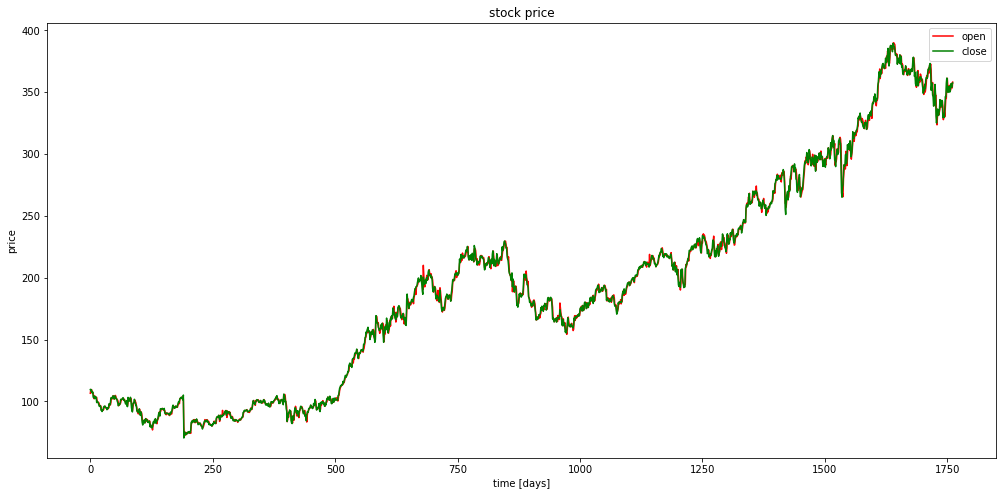

In [11]:
plt.figure(figsize=(17, 8));

plt.plot(df[df.symbol == 'EQIX'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'EQIX'].close.values, color='green', label='close')

plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()




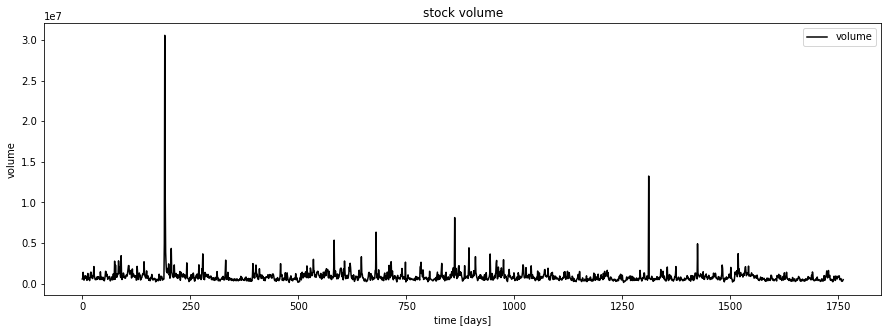

In [12]:
plt.figure(figsize=(15, 5));

plt.plot(df[df.symbol == 'EQIX'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [13]:
# Manipulate data
# choose a specific stock
# function for min-max normalization of stock

def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df
    

In [14]:
# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
     # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [15]:
# choose one stock
df_stock = df[df.symbol == 'NSC'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

In [16]:
df_stock.head()

,open,close,low,high
date,,,,
2010-01-04,52.830002,52.590000,52.040001,52.830002
2010-01-05,52.560001,53.400002,52.500000,53.619999
2010-01-06,53.130001,53.250000,53.009998,53.959999
2010-01-07,53.009998,52.549999,52.110001,53.029999
2010-01-08,52.439999,54.360001,52.439999,54.759998


In [17]:
df_stock.tail()

,open,close,low,high
date,,,,
2016-12-23,108.660004,109.279999,108.190002,109.790001
2016-12-27,109.339996,109.449997,109.320000,109.870003
2016-12-28,109.410004,108.720001,108.620003,110.260002
2016-12-29,108.860001,108.820000,107.769997,109.320000
2016-12-30,108.849998,108.070000,107.500000,108.989998


In [18]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# choose one stock
df_stock = df[df.symbol == 'EQIX'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

df_stock.columns.values =  ['open', 'close', 'low', 'high']
x_train.shape =  (1394, 19, 4)
y_train.shape =  (1394, 4)
x_valid.shape =  (174, 19, 4)
y_valid.shape =  (174, 4)
x_test.shape =  (174, 19, 4)
y_test.shape =  (174, 4)


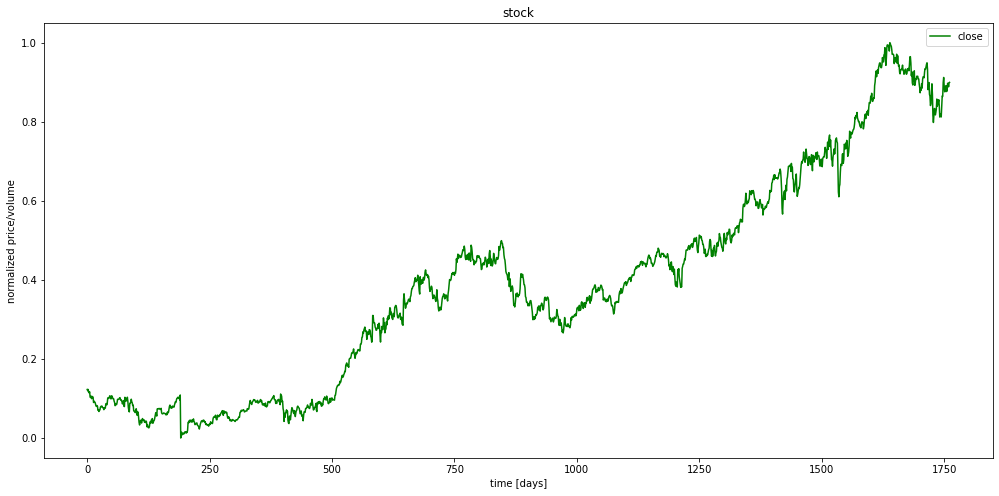

In [19]:
plt.figure(figsize=(17, 8));

plt.plot(df_stock_norm.close.values, color='green', label='close')

plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()


## Clearly, you see that this is not a stationary process, and it is hard to tell if there is some kind of seasonality.

## Let’s use the moving average model to smooth our time series. For that, we will use a helper function that will run the moving average model on a specified time window and it will plot the result smoothed curve:

In [20]:
def plot_moving_average(series, window, plot_intervals = False, scale=1.96):
    
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(15,5))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean,'g',label = 'Rolling mean trend')
    
    #plot confidence intervals for smoothed values
    
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--')
        plt.plot(lower_bound, 'r--')
        
    plt.plot(series[window:], label = 'Actual values')
    plt.legend(loc = 'best')
    plt.grid(True)

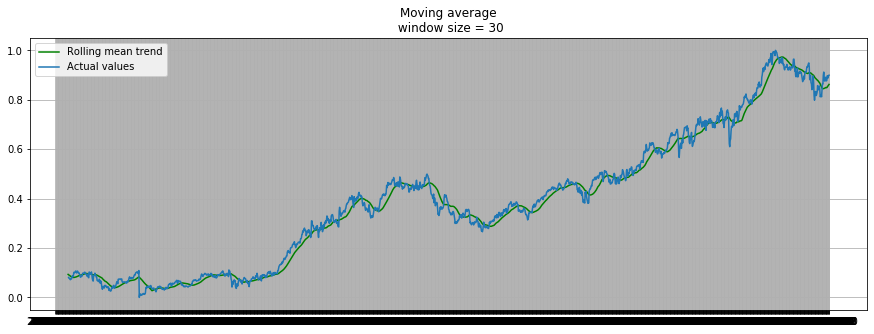

In [21]:
#smooth by previous 5 days(by week)
plot_moving_average(df_stock_norm.close,30)

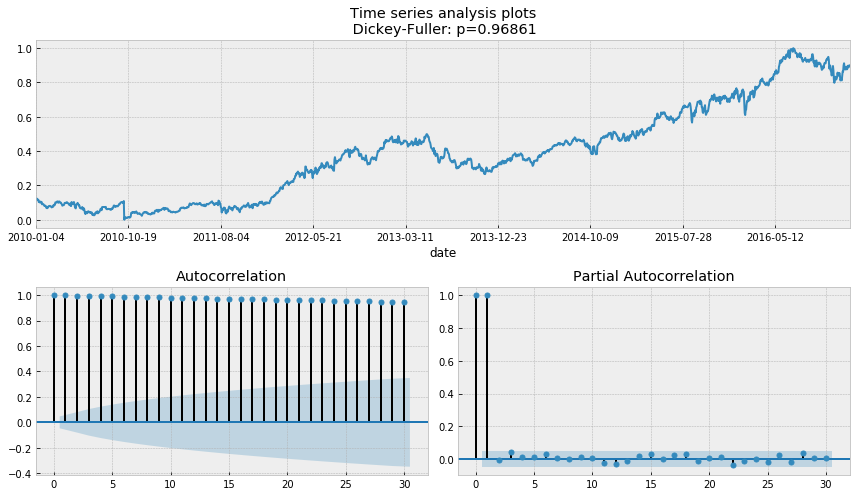

In [22]:
def tsplot(y, lags = None, figsize =(12,7), syle = 'bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    with plt.style.context(style = 'bmh'):
        fig = plt.figure(figsize = figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0),colspan = 2)
        acf_ax = plt.subplot2grid(layout,(1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax = ts_ax)
        p_value = smt.stattools.adfuller(y)[1]
        ts_ax.set_title('Time series analysis plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags = lags,ax=acf_ax)
        smt.graphics.plot_pacf(y, lags = lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(df_stock_norm.close, lags =30)

## By the Dickey-Fuller test, the time series is unsurprisingly non-stationary. Also, looking at the autocorrelation plot, we see that it is very high, and it seems that there is no clear seasonality.
## Therefore, to get rid of the high autocorrelation and to make the process stationary, let’s take the first difference. We simply the time series from itself with a lag of one day:

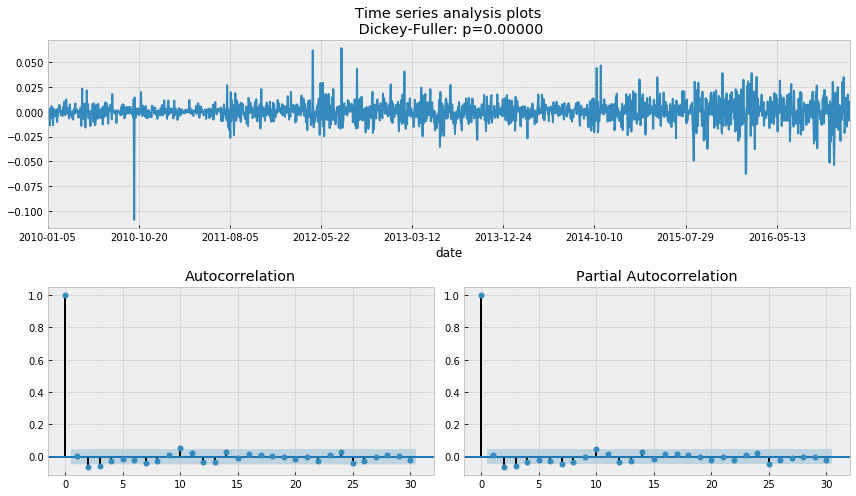

In [23]:
df_diff =  df_stock_norm.close - df_stock_norm.close.shift(1)
tsplot(df_diff[1:], lags = 30)

In [24]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

In [25]:
# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]


In [26]:
# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [27]:
# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train})
            
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.dense instead.
0.00 epochs: MSE train/valid = 0.135113/0.446478
4.99 epochs: MSE train/valid = 0.000238/0.001378
9.97 epochs: MSE train/valid = 0.000242/0.000855
14.96 epochs: MSE train/valid = 0.000154/0.000601
19.94 epochs: MSE train/valid = 0.000125/0.000630
24.93 epochs: MSE train/valid = 0.000105/0.000440
29.91 epochs: MSE train/valid = 0.000128/0.000560
34.90 epochs: MSE train/valid = 0.000095/0.000320
39.89 epochs: MSE train/valid = 0.000087/0.000369
44.87 epochs: MSE train/va

In [31]:
y_train.shape

(1394, 4)

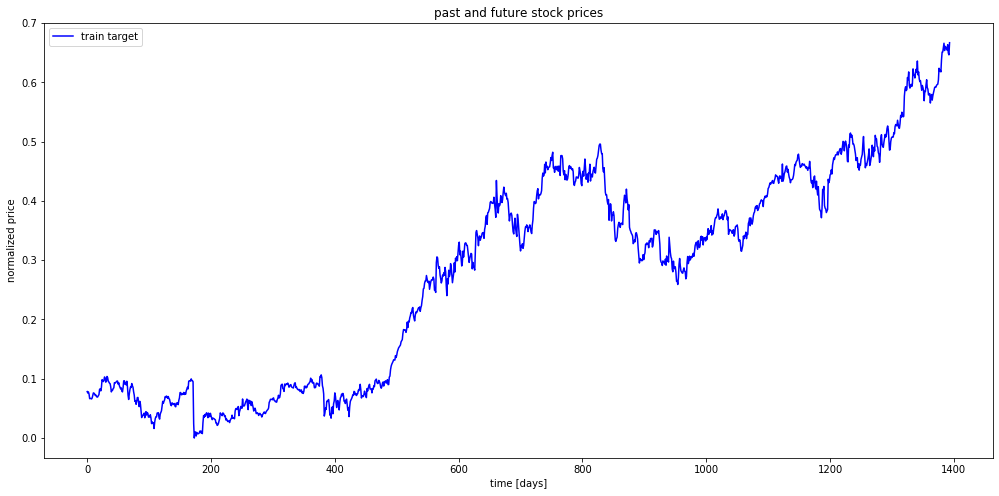

In [30]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(17, 8));


plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

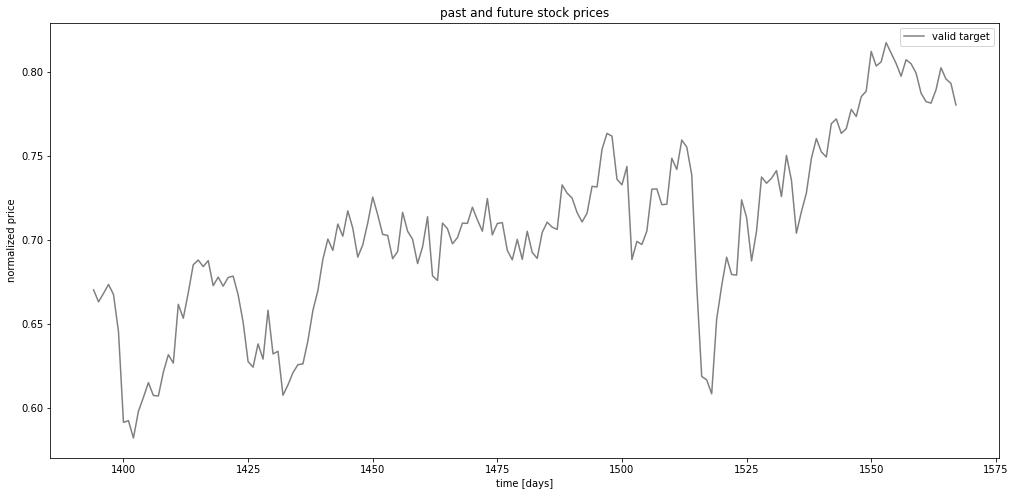

In [37]:
plt.figure(figsize=(17, 8));
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

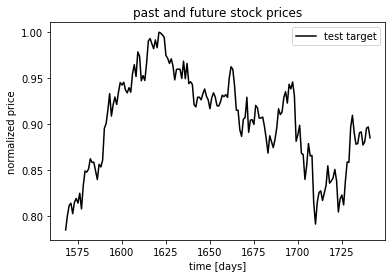

In [32]:
plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')
plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');


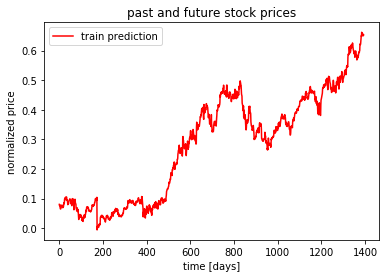

In [33]:
plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

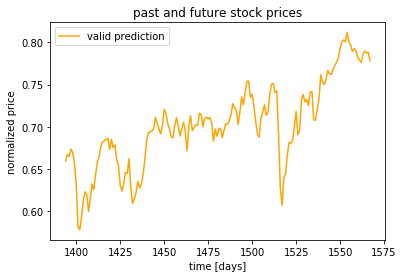

In [34]:
plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

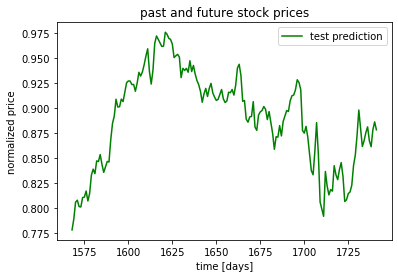

In [35]:
plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

correct sign prediction for close - open price for train/valid/test: 0.75/0.64/0.61


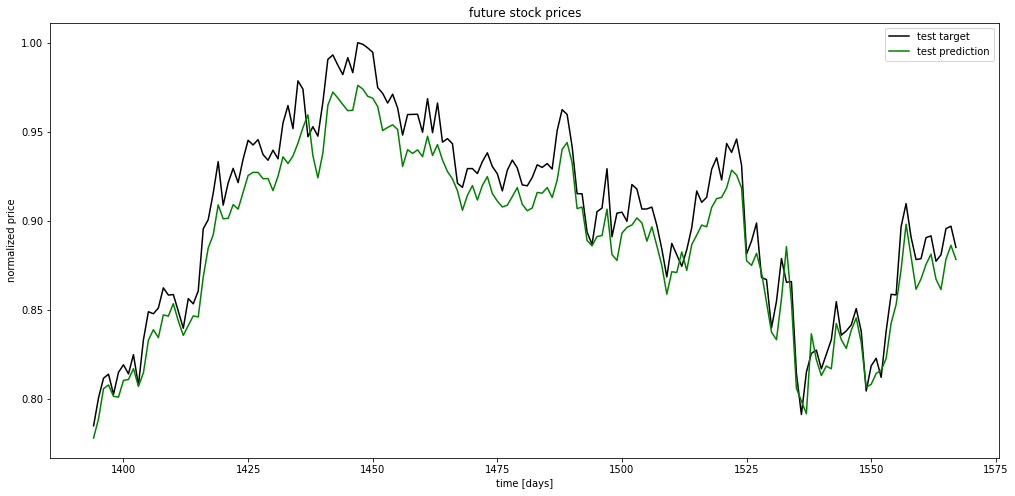

In [36]:
plt.figure(figsize=(17,8));


plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))

In [40]:
mean_absolute_percentage_error(y_test,y_test_pred)

1.3445880460068105